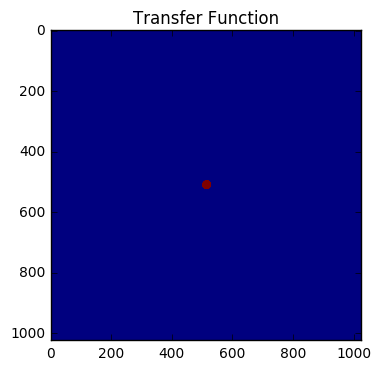

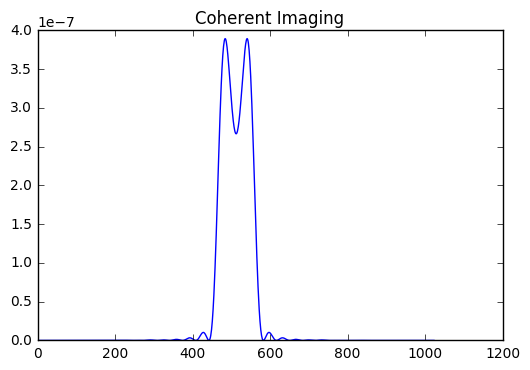

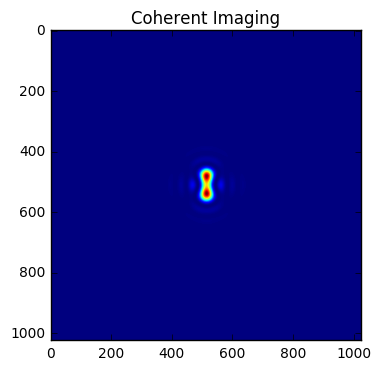

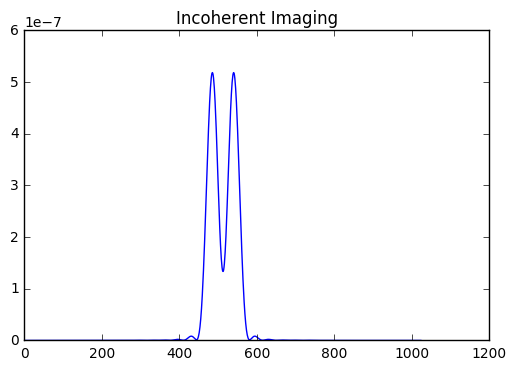

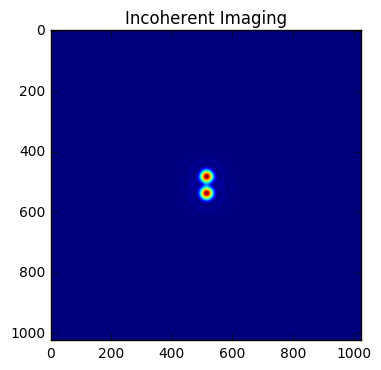

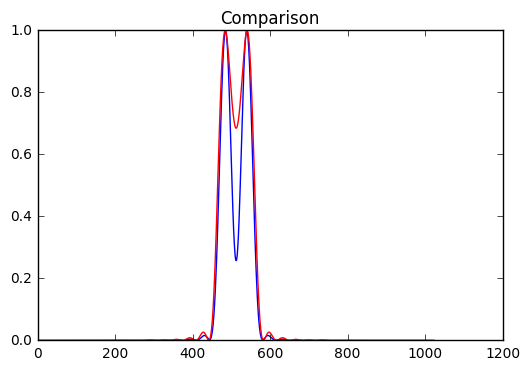

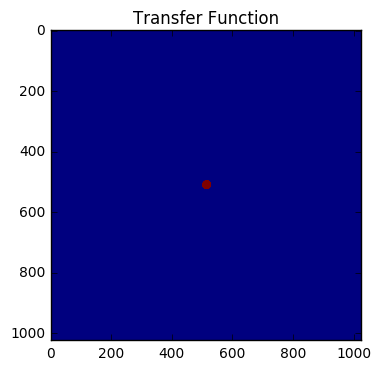

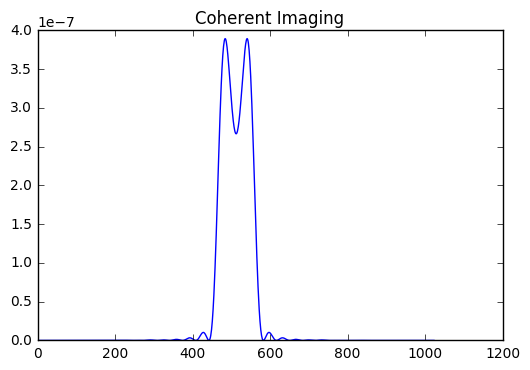

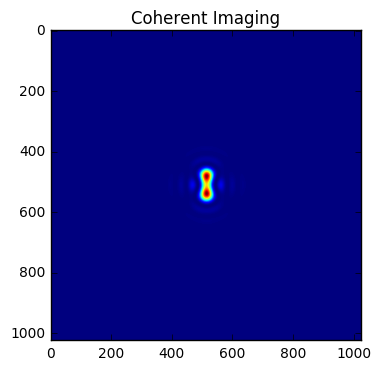

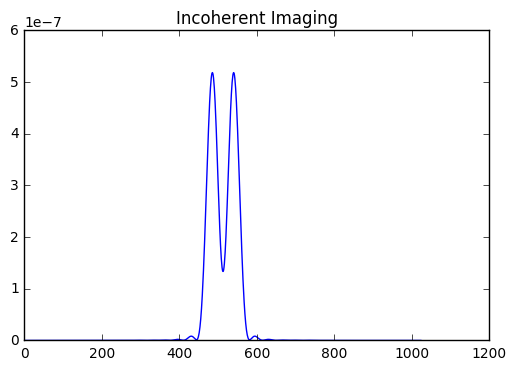

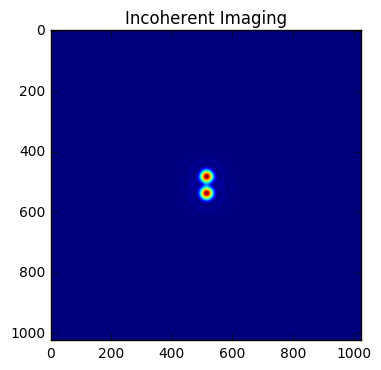

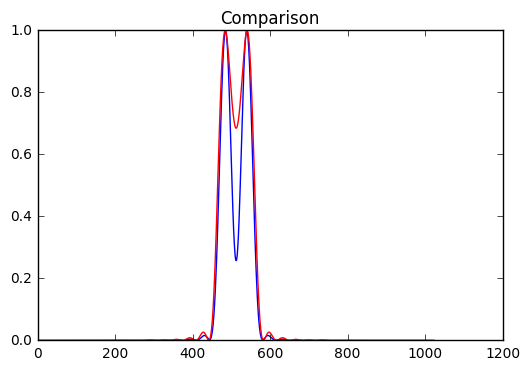

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 13 18:13:16 2018

@author: vganapa1
"""
import numpy as np
import matplotlib.pyplot as plt
import math

#F = lambda x: np.fft.fft2(np.fft.fftshift(x))        Her code
#Ft = lambda x: np.fft.ifftshift(np.fft.ifft2(x))

F = lambda x: np.fft.fftshift(np.fft.fft2(np.fft.fftshift(x)))
Ft = lambda x: np.fft.ifftshift(np.fft.ifft2(x))

def create_point(Nx,Ny,x,y):
    point = np.zeros([Nx, Ny], dtype = np.complex64)
    point[Nx/2 - x, Ny/2 - y] = 1
    return point

def fresnel_prop(u0,dx,dy,z,wavelength): # x is the row coordinate, y is the column coordinate
    Nx = u0.shape[0]
    Ny = u0.shape[1]
    Lx = Nx*dx
    Ly = Ny*dy
    
    U0 = F(u0)
    
    fx=np.linspace(-1/(2*dx),1/(2*dx)-1/Lx,Nx) #freq coords
    fy=np.linspace(-1/(2*dy),1/(2*dy)-1/Ly,Ny) #freq coords
    
    FX,FY=np.meshgrid(fx,fy, indexing = 'ij')

    H_fresnel=np.exp(-1j*math.pi*wavelength*z*(FX**2+FY**2))
    H_fresnel=np.fft.fftshift(H_fresnel)
    
    U1 = U0*H_fresnel
    u1 = Ft(U1)
    
    return u1


def NAfilter(m,L,wavelength,NA):
    #m is the number of points in the source plane field (asuume square field)
    #L is the side length of the observation and source fields (assume square field)
    #wavelength is the free space wavelength

    dx=L/m
    k=1./wavelength #wave number 
    fx=np.linspace(-1/(2*dx),1/(2*dx)-1/L,m) #freq coords

    FX,FY=np.meshgrid(fx,fx)
    
    H=np.zeros([m,m], dtype=np.complex64)
    H[np.nonzero(np.sqrt(FX**2+FY**2)<=NA*k)]=1.


    H=np.fft.fftshift(H)

    return H    

def filter_function_NA(u1,H_NA,Nx,incoherent=True):
    #u1 is the source plane field
    #Nx is u1.shape[0]
    #dx is L/m

    H = H_NA

    if incoherent:
        H=np.fft.fft2(np.fft.ifft2(H)*np.conj(np.fft.ifft2(H)))

        U1=np.fft.fftshift(u1)
        U1=np.fft.fft2(U1)

        U2=H*U1
        u2=np.fft.fftshift(np.fft.ifft2(U2))

    else:
        U1=np.fft.fftshift(u1)
        U1=np.fft.fft2(U1)

        U2=H*U1
        u2=np.fft.fftshift(np.fft.ifft2(U2))

    return u2

def create_2_points(Nx,Ny,x0,y0,x1,y1):
    point = np.zeros([Nx, Ny], dtype = np.complex64)
    point[Nx//2 - x0, Ny//2 - y0] = 1
    point[Nx//2 - x1, Ny//2 - y1] = 1
    return point

if __name__ == '__main__':
    
    Nx = 2**10
    Ny = 2**10
    wavelength = 500e-9
    NA = 0.75
    dx = 10e-9
    L = dx*Nx
    del_x = 55
    
    u0 = create_2_points(Nx,Ny,-del_x//2,0,del_x//2,0)
    H_NA = NAfilter(Nx,L,wavelength,NA)
    coherent_intensity = np.abs(filter_function_NA(u0,H_NA,Nx,incoherent=False))**2
    incoherent_intensity = np.abs(filter_function_NA(u0,H_NA,Nx,incoherent=True))**2
    
    plt.figure()
    plt.imshow(np.fft.fftshift(np.abs(H_NA)))
    plt.title('Transfer Function')
    
    plt.figure()
    plt.plot(coherent_intensity[:,Ny//2])
    plt.title('Coherent Imaging')
    
    plt.figure()
    plt.imshow(coherent_intensity)
    plt.title('Coherent Imaging')
    
    plt.figure()
    plt.plot(incoherent_intensity[:,Ny//2])
    plt.title('Incoherent Imaging')
    
    plt.figure()
    plt.imshow(incoherent_intensity)
    plt.title('Incoherent Imaging')

    plt.figure()
    plt.title('Comparison')
    plt.plot(incoherent_intensity[:,Ny//2]/np.max(incoherent_intensity[:,Ny//2]))
    plt.plot(coherent_intensity[:,Ny//2]/np.max(coherent_intensity[:,Ny//2]), 'r')
    
    plt.show()